# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Homework 5: Logistic Regression, High Dimensionality and PCA


**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">



In [217]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas  https://canvas.harvard.edu/courses/42693/pages/homework-policies-and-submission-instructions.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.

Names of people you have worked with goes here: 

<hr style="height:2pt">

In [218]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

import math
from scipy.special import gamma

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from IPython.display import display


<div class='theme'> Cancer Classification from Gene Expressions </div>

In this problem, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The data set is provided in the file `data/dataset_hw5_1.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with 0 indicating the ALL class and 1 indicating the AML class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will use linear and logistic regression to build classification models for this data set. We will also use Principal Components Analysis (PCA) to reduce its dimensions. 



<div class='exercise'><b> Question 1 [25 pts]: Data Exploration </b></div>

First step is to  split  the observations into an approximate 50-50 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits).

**1.1** Take a peek at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.

**1.2** Notice that the resulting training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?  Explain in 3 or fewer sentences.

**1.3** Let's explore a few of the genes and see how well they discriminate between cancer classes. Create a single figure with four subplots arranged in a 2x2 grid. Consider the following four genes: `D29963_at`, `M23161_at`, `hum_alu_at`, and `AFFX-PheX-5_at`. For each gene overlay two histograms of the gene expression values on one of the subplots, one histogram for each cancer type. Does it appear that any of these genes discriminate between the two classes well? How are you able to tell?

**1.4** Since our data has dimensions that are not easily visualizable, we want to reduce the dimensionality of the data to make it easier to visualize. Using PCA, find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the two cancer types in different colors and different markers ('x' vs 'o', for example). How well do the top two principal components discriminate between the two classes? How much of the variance within the predictor set do these two principal components explain? 

**1.5** Plot the cumulative variance explained in the feature set...

#### Answers:
First step is to split the observations into an approximate 50-50 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits).

In [284]:
np.random.seed(9002)
df = pd.read_csv('data/dataset_hw5_1.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

**1.1:** Take a peek at your training set...

In [285]:
# your code here
data_train.head()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0,-214,-153,-58,88,-295,-558,199,-176,252,...,185,511,-125,389,-37,793,329,36,191,-37
2,0,-106,-125,-76,168,-230,-284,4,-122,70,...,156,649,57,504,-26,250,314,14,56,-25
5,0,-67,-93,84,25,-179,-323,-135,-127,-2,...,48,224,60,194,-10,291,41,8,-2,-80
9,0,-476,-213,-18,301,-403,-394,-42,-144,98,...,241,1214,127,255,50,1701,1108,61,525,-83
10,0,-81,-150,-119,78,-152,-340,-36,-141,96,...,186,573,-57,694,-19,636,205,17,127,-13


In [286]:
def normalize_columns(labels, df, scaler=None):
    if scaler is None:
        scaler = MinMaxScaler().fit(df.loc[:,labels])
        df.loc[:,labels] = scaler.transform(df.loc[:,labels].copy())
    else:
        df.loc[:,labels] = scaler.transform(df.loc[:,labels].copy())
    return df

def normalize_dfs(labels, df_train, df_test=None):
    scaler = MinMaxScaler().fit(df_train.loc[:,labels]) #fit scaler to training data
    df_train = normalize_columns(labels, df_train, scaler) #transform training data
    if df_test is None:    
        return df_train
    else:
        df_test = normalize_columns(labels,df_test,scaler) #transform test data by training scaler
        return df_train, df_test

In [287]:
std_cols = df.columns.difference(['Cancer_type'])
#df = normalize_columns(df,std_cols) #for the sake of having a fully normalized set
data_train, data_test = normalize_dfs(std_cols, data_train, data_test)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [290]:
data_train.head()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0,0.466192,0.739726,0.255814,0.246154,0.433190,0.240418,0.880427,0.625850,0.928074,...,0.385445,0.268542,0.398126,0.161897,0.677778,0.323241,0.322609,0.751381,0.069457,0.381720
2,0,0.658363,0.794521,0.213953,0.421978,0.573276,0.717770,0.741637,0.748299,0.505800,...,0.307278,0.356777,0.824356,0.206978,0.718519,0.081478,0.309565,0.629834,0.027597,0.446237
5,0,0.727758,0.857143,0.586047,0.107692,0.683190,0.649826,0.642705,0.736961,0.338747,...,0.016173,0.085038,0.831382,0.085457,0.777778,0.099733,0.072174,0.596685,0.009612,0.150538
9,0,0.000000,0.622309,0.348837,0.714286,0.200431,0.526132,0.708897,0.698413,0.570766,...,0.536388,0.718031,0.988290,0.109369,1.000000,0.727516,1.000000,0.889503,0.173023,0.134409
10,0,0.702847,0.745597,0.113953,0.224176,0.741379,0.620209,0.713167,0.705215,0.566125,...,0.388140,0.308184,0.557377,0.281458,0.744444,0.253339,0.214783,0.646409,0.049612,0.510753


**1.2:** Notice that the resulting training set contains...

In [291]:
data_train.shape

(40, 7130)

We have many more predictors than observations (as shown in the `data_train` shape above). Trying to regress data that has significantly more predictors than observations like our data does will lead to ridiculous variance and overfitting

**1.3:** Let's explore a few of the genes...

In [294]:
def explore_genes(df, gene_list, fig, axes):
    #Visually explore genes by cancer type
    axes_list=[]
    for ax in axes:
        for a in ax:
            axes_list.append(a)
    for ctr, gene in enumerate(gene_list,0):
        type_0 = df[df['Cancer_type']==0][gene]
        type_1 = df[df['Cancer_type']==1][gene]
        axes_list[ctr].hist(type_0, alpha=0.5, density=True) #normed or no???
        axes_list[ctr].hist(type_1, alpha=0.5, density=True)
        axes_list[ctr].legend(["ALL","AML"])
        axes_list[ctr].set_title(gene)
        axes_list[ctr].set_xlabel("Expression Value")
        axes_list[ctr].set_ylabel("Frequency")

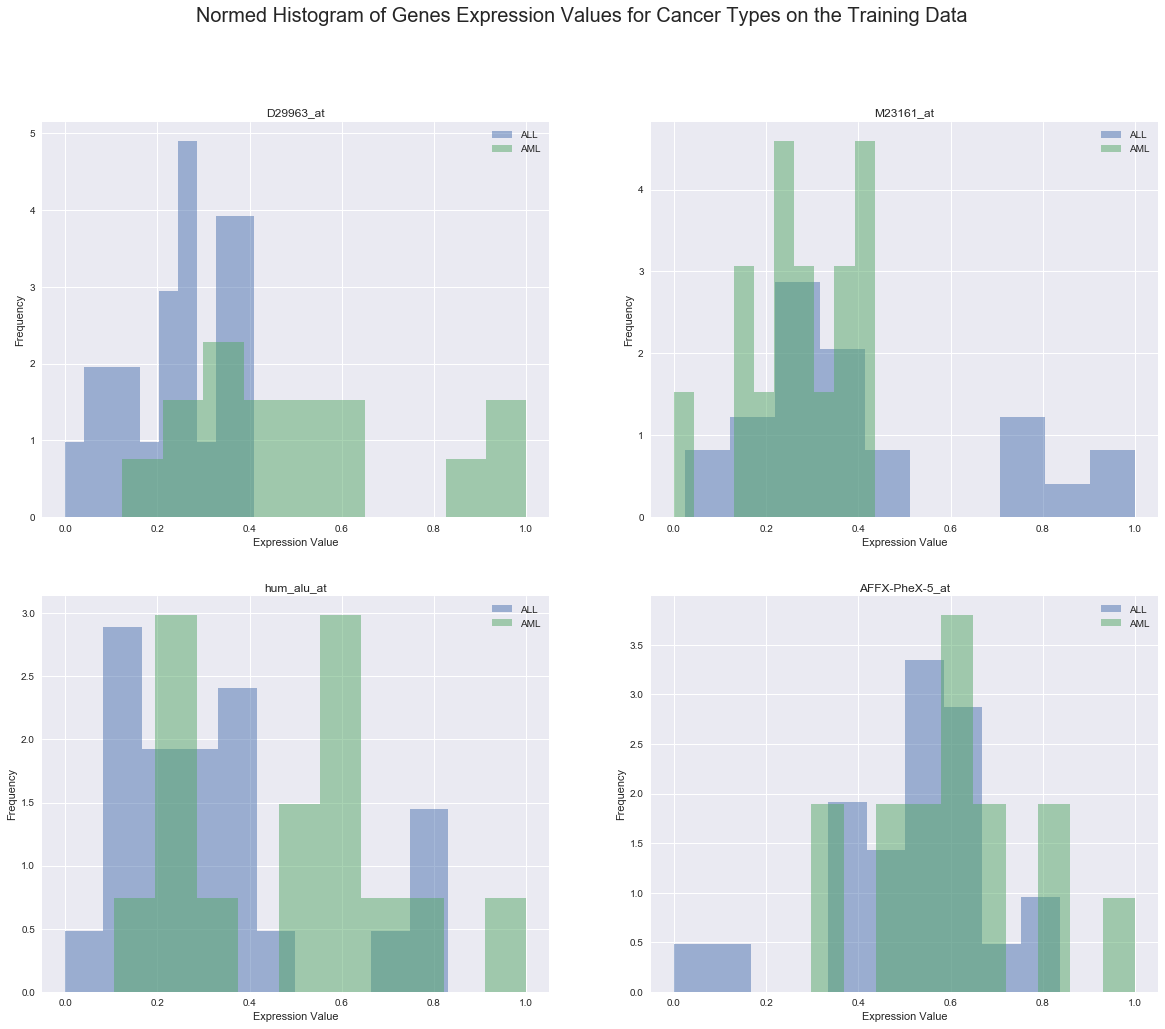

In [295]:
fig, axes = plt.subplots(2,2,figsize=(20,16))
fig.suptitle("Normed Histogram of Genes Expression Values for Cancer Types on the Training Data", fontsize=20)
gene_list = ['D29963_at','M23161_at','hum_alu_at','AFFX-PheX-5_at']
explore_genes(data_train,gene_list,fig,axes) #run on training data

We use a normed histogram because we want to determine whether a gene discriminates between cancer types because we do not care about the sample bias (more people may absolutely have one type of cancer over the other). 

Gene expressions with overlapping frequencies have low predictive value because both cancer classes share those gene expressions commonly. To analyze which gene expressions are able to discriminate between classes, we focus on the genes that have different peaks on the histograms. Perhaps higher expression values of `D29963_at` leads to a higher chance of AML cancer. For `M23161_at`, a higher expression value may mean that the cancer type is ALL. `hum_alu_at` expression values do dont discrimate between cancer types very well. Lastly, `AFFX-Phex-5_at` is imperfect at discriminating between cancer types, however a low expression value may indicate ALL cancer. 

**1.4:** Since our data has dimensions that are not easily visualizable, we want to reduce the dimensionality of the data to make it easier to visualize. Using PCA, find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the two cancer types in different colors and different markers ('x' vs 'o', for example). How well do the top two principal components discriminate between the two classes? How much of the variance within the predictor set do these two principal components explain?

In [296]:
x_train = data_train.drop(columns=['Cancer_type'])
x_test = data_test.drop(columns=['Cancer_type'])
y_train = data_train['Cancer_type']
y_test = data_test['Cancer_type']

In [297]:
# reduce dimensions
pca_transformer_2 = PCA(2).fit(x_train)
x_train_2d = pca_transformer_2.transform(x_train)

Text(0,0.5,'PCA Dimention 2')

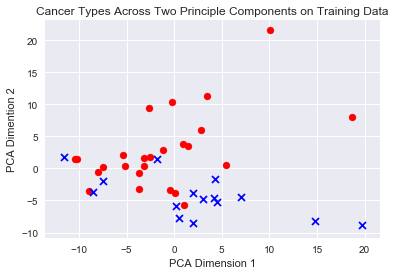

In [298]:
colors = ['r','b']
label_text=["ALL","AML"]
markers = ['o','x']
for cur_cancer in [0,1]:
    cur_df = x_train_2d[y_train==cur_cancer]
    plt.scatter(cur_df[:,0], cur_df[:,1], c = colors[cur_cancer], 
                label=label_text[cur_cancer], marker=markers[cur_cancer])

plt.title("Cancer Types Across Two Principle Components on Training Data")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimention 2")

In [299]:
print("Variance explained by 2 principle components: %.2f"
      %pca_transformer_2.explained_variance_ratio_.cumsum()[1])

Variance explained by 2 principle components: 0.27


Its definitely not perfect. We roughly see an overlap for PCA Dimension 1 from -15 to 0 and PCA Dimension 2 from -5 to 5. For higher PCA Dimension 1 values we may be able to distinguish between the two cancers, but overall this model is not good enough.

**1.5**: Plot the cumulative variance explained in the feature set as a function of the number of PCA-components (up to the first 50 components).  Do you feel 2 components is enough, and if not, how many components would you choose to consider?  Justify your choice in 3 or fewer sentences.  Finally, determine how many components are needed to explain at least 90% of the variability in the feature set. 

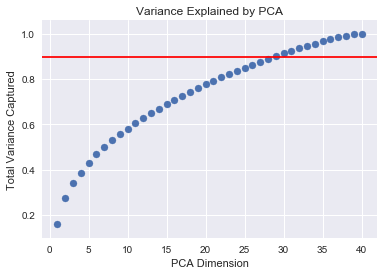

In [300]:
# your code here
pca_transformer_50 = PCA(50).fit(x_train)
x_train_50d = pca_transformer_50.transform(x_train)
plt.scatter(range(1,len(pca_transformer_50.explained_variance_ratio_)+1),
            pca_transformer_50.explained_variance_ratio_.cumsum())
plt.title("Variance Explained by PCA")
plt.xlabel("PCA Dimension")
plt.ylabel("Total Variance Captured")
plt.axhline(y=0.9, color='r', linestyle='-')

In [301]:
print("29 principle components explain %.2f"%pca_transformer_50.explained_variance_ratio_.cumsum()[28]+" variance")

29 principle components explain 0.90 variance


If we use more principle components, we risk overfitting. Since there are not that many observations, we want to limit the amount of principle components we use. 2 principle components seems like too little as it only captures 0.27 variance. It seems desirable to caputure at least 50% of the variance. We can do this with 7 principle components (which captures 0.53 variance). This does not seem like too many (as there are 40 components overall) so 7 principle components seems like the best choice for the sake of this question. More analysis could tell us about the risks of overfitting.

<div class='exercise'> <b> Question 2 [25 pts]: Linear Regression vs. Logistic Regression </b> </div>

In class we discussed how to use both linear regression and logistic regression for classification. For this question, you will work with a single gene predictor, `D29963_at`, to explore these two methods.

**2.1** Fit a simple linear regression model to the training set using the single gene predictor `D29963_at` to predict cancer type and plot the histogram of predicted values. We could interpret the scores predicted by the regression model for a patient as an estimate of the probability that the patient has `Cancer_type`=1 (AML). Is there a problem with this interpretation?

**2.2** The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary classes 0 or 1) by classifying patients with predicted score greater than 0.5 into `Cancer_type`=1, and the others into the `Cancer_type`=0. Evaluate the classification accuracy of the obtained classification model on both the training and test sets.

**2.3** Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? If there are no substantial differences, why do you think this happens? 

Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to **not** regularize (use 'C=100000').  

**2.4** Create a figure with 4 items displayed on the same plot:
- the quantitative response from the linear regression model as a function of the gene predictor `D29963_at`.
- the predicted probabilities of the logistic regression model as a function of the gene predictor `D29963_at`.  
- the true binary response for the test set points for both models in the same plot. 
- a horizontal line at $y=0.5$. 

Based on these plots, does one of the models appear better suited for binary classification than the other?  Explain in 3 sentences or fewer. 




#### Answers: 

**2.1:** Fit a simple linear regression model to the training set

Text(0,0.5,'Frequency')

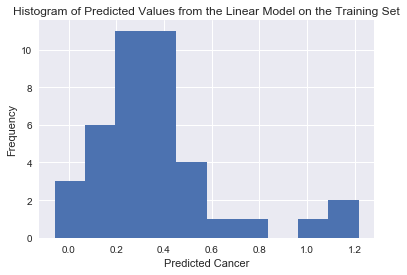

In [322]:
x_D2_train_cst = sm.add_constant(x_train['D29963_at'])
x_D2_test_cst = sm.add_constant(x_test['D29963_at'])
model_OLS = OLS(y_train,x_D2_train_cst).fit()
y_train_pred = model_OLS.predict(x_D2_train_cst) #on training data
plt.hist(y_train_pred)
plt.title("Histogram of Predicted Values from the Linear Model on the Training Set")
plt.xlabel("Predicted Cancer")
plt.ylabel("Frequency")

The problem with this interpretation is that the OLS regression we’re using treats Cancer_type as a continuous variable when it is actually a binary variable (Categorical response variable) instead. As a result, our model predicts a spike of predicted cancer around 0.4 which is nonsensical because predicted cancer can only be 0 or 1, meaning ALL or AML respectively. 

**2.2:** The fitted linear regression model can be converted to a classification model...

Text(0.5,1,'Classification Model Histogram of Predicted Cancer')

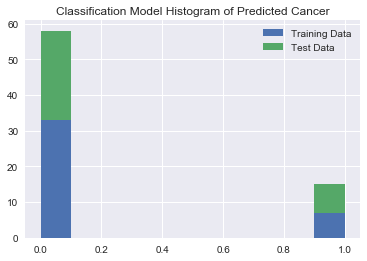

In [323]:
y_test_pred = model_OLS.predict(x_D2_test_cst)

y_train_pred_class = pd.cut(y_train_pred,[-1,0.5,2], labels=[0,1])
y_test_pred_class = pd.cut(y_test_pred,[-1,0.5,2], labels=[0,1])
plt.hist([y_train_pred_class,y_test_pred_class], stacked=True)
plt.legend(["Training Data", "Test Data"])
plt.title("Classification Model Histogram of Predicted Cancer")

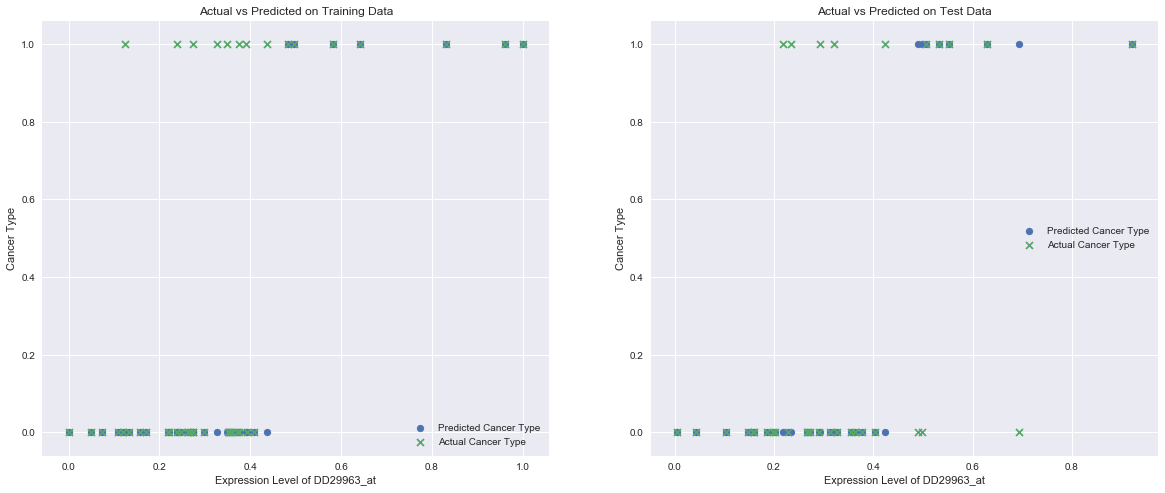

In [327]:
fig, axes = plt.subplots(1,2,figsize=(20,8))
axes[0].scatter(x_train['D29963_at'],y_train_pred_class, label="Predicted Cancer Type", marker = "o")
axes[0].scatter(x_train['D29963_at'],y_train, label="Actual Cancer Type", marker = "x")
axes[0].set_xlabel('Expression Level of DD29963_at')
axes[0].set_ylabel('Cancer Type')
axes[0].set_title("Actual vs Predicted on Training Data")
axes[0].legend()

axes[1].scatter(x_test['D29963_at'],y_test_pred_class, label="Predicted Cancer Type", marker="o")
axes[1].scatter(x_test['D29963_at'],y_test, label="Actual Cancer Type", marker = "x")
axes[1].set_xlabel('Expression Level of DD29963_at')
axes[1].set_ylabel('Cancer Type')
axes[1].set_title("Actual vs Predicted on Test Data")
axes[1].legend()

In [325]:
print("The classification accuracy for the linear model on the training set is %.2f"
      %accuracy_score(y_train,y_train_pred_class))
print("The classification accuracy for the linear model on the test set is %.2f"
      %accuracy_score(y_test,y_test_pred_class))

The classification accuracy for the linear model on the training set is 0.80
The classification accuracy for the linear model on the test set is 0.76


**2.3:** Next, fit a simple logistic regression model to the training set... How do the training and test classification accuracies of this model compare with the linear regression model? If there are no substantial differences, why do you think this happens?

In [340]:
model_LR = LogisticRegression(C=100000, solver='newton-cg', max_iter=250).fit(x_D2_train_cst,y_train)

y_train_pred_LR = model_LR.predict(x_D2_train_cst)
y_test_pred_LR = model_LR.predict(x_D2_test_cst)

print("The classification accuracy for the logistic regression on the training set is %.2f"
      %accuracy_score(y_train,y_train_pred_LR))
print("The classification accuracy for the logistic regression on the test set is %.2f"
      %accuracy_score(y_test,y_test_pred_LR))

The classification accuracy for the logistic regression on the training set is 0.80
The classification accuracy for the logistic regression on the test set is 0.76


They are the same. Why?????????????

**2.4:** Create a figure with 4 items displayed on the same plot:
- the quantitative response from the linear regression model as a function of the gene predictor `D29963_at`.
- the predicted probabilities of the logistic regression model as a function of the gene predictor `D29963_at`.  
- the true binary response for the test set points for both models in the same plot. 
- a horizontal line at $y=0.5$. 

Based on these plots, does one of the models appear better suited for binary classification than the other?  Explain in 3 sentences or fewer. 

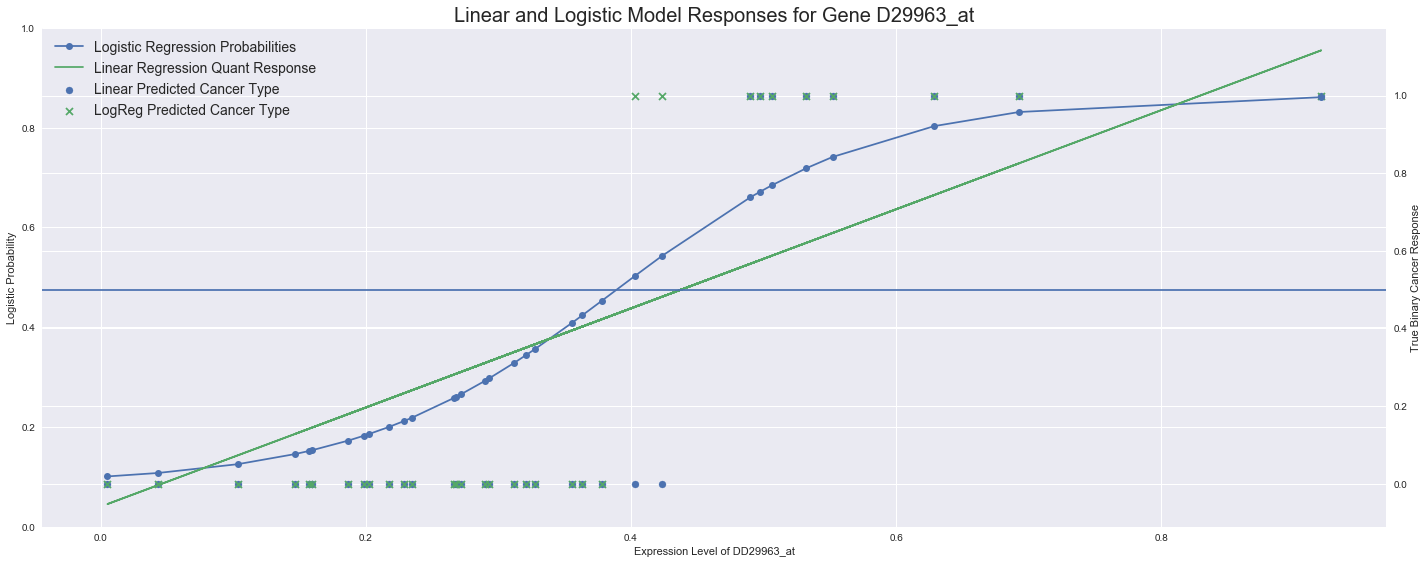

In [405]:
fig, ax1 = plt.subplots(figsize=(20,8))
plt.title("Linear and Logistic Model Responses for Gene D29963_at", fontsize=20)
plt.xlabel("Expression Level of DD29963_at")
plt.ylabel("Logistic Probability")
ax2 = ax1.twinx()
ax2.
ax2.set_ylabel("True Binary Cancer Response")

plt.scatter(x_test['D29963_at'],y_test_pred_class, label="Linear Predicted Cancer Type", marker="o")
plt.scatter(x_test['D29963_at'],y_test_pred_LR, label="LogReg Predicted Cancer Type", marker="x")

x_sort = list(x_test['D29963_at'])
x_sort.sort()
y_sort_LR = model_LR.predict_proba(x_D2_test_cst)[:,1]
y_sort_LR.sort()
plt.plot(x_sort, y_LR, label="Logistic Regression Probabilities", marker = "o")
plt.plot(x_test['D29963_at'], y_test_pred, label="Linear Regression Quant Response")

plt.axhline(y=0.5)
plt.legend(fontsize=14)
plt.tight_layout()

*your answer here*


<div class='exercise'> <b> Question 3 [30pts]: Multiple Logistic Regression </b> </div>


**3.1** Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?  


**3.2** How many of the coefficients estimated by this multiple logistic regression in the previous part are significantly different from zero at a *significance level of 5%*? Use the same value of C=100000 as before.

**Hint:** To answer this question, use *bootstrapping* with 1000 boostrap samples/iterations.  

**3.3** Use the `visualize_prob` function provided below (or any other visualization) to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the different cancer classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line. Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?

**3.4** Open question: Comment on the classification accuracy of the train and test sets. Given the results above how would you assess the generalization capacity of your trained model?  What other tests or approaches would you suggest to better guard against the false sense of security on the accuracy of the model as a whole. 


In [144]:
#--------  visualize_prob
# A function to visualize the probabilities predicted by a Logistic Regression model
# Input: 
#      model (Logistic regression model)
#      x (n x d array of predictors in training data)
#      y (n x 1 array of response variable vals in training data: 0 or 1)
#      ax (an axis object to generate the plot)

def visualize_prob(model, x, y, ax):
    # Use the model to predict probabilities for x
    y_pred = model.predict_proba(x)
    
    # Separate the predictions on the label 1 and label 0 points
    ypos = y_pred[y==1]
    yneg = y_pred[y==0]
    
    # Count the number of label 1 and label 0 points
    npos = ypos.shape[0]
    nneg = yneg.shape[0]
    
    # Plot the probabilities on a vertical line at x = 0, 
    # with the positive points in blue and negative points in red
    pos_handle = ax.plot(np.zeros((npos,1)), ypos[:,1], 'bo', label = 'Cancer Type 1')
    neg_handle = ax.plot(np.zeros((nneg,1)), yneg[:,1], 'ro', label = 'Cancer Type 0')

    # Line to mark prob 0.5
    ax.axhline(y = 0.5, color = 'k', linestyle = '--')
    
    # Add y-label and legend, do not display x-axis, set y-axis limit
    ax.set_ylabel('Probability of AML class')
    ax.legend(loc = 'best')
    ax.get_xaxis().set_visible(False)
    ax.set_ylim([0,1])

#### Answers:

**3.1:** Next, fit a multiple logistic regression model with all the gene predictors...

In [145]:
# your code here


*your answer here*


**3.2:** How many of the coefficients estimated by this multiple logistic regression...

In [148]:
# bootstrapping code
# your code here


*your answer here*


**3.3:** Use the visualize_prob function provided below ...

In [147]:
""" Plot classification model """

# your code here


*your answer here*


**3.4:** Open question: Comment on the classification accuracy...


*your answer here* 


<div class='exercise'><b> Question 4 [20 pts]: PCR: Principal Components Regression </b></div>

High dimensional problems can lead to problematic behavior in model estimation (and make prediction on a test set worse), thus we often want to try to reduce the dimensionality of our problems. A reasonable approach to reduce the dimensionality of the data is to use PCA and fit a logistic regression model on the smallest set of principal components that explain at least 90% of the variance in the predictors.

**4.1:** Fit two separate Logistic Regression models using principal components as the predictors: (1) with the number of components you selected from problem 1.5 and (2) with the number of components that explain at least 90% of the variability in the feature set. How do the classification accuracy values on both the training and tests sets compare with the models fit in question 3?   

**4.2:** Use the code provided in question 3 (or your choice of visualization) to visualize the probabilities predicted by the fitted models in the previous part on both the training and test sets. How does the spread of probabilities in these plots compare to those for the model in question 3.2? If the lower dimensional representation yields comparable predictive power, what advantage does the lower dimensional representation provide?


#### Answers:

**4.1:** Fit two separate Logistic Regression models...

In [140]:
# your code here


*your answer here*


**4.2:** Use the code provided in question 3...

In [284]:
# your code here


*your answer here*